In [1]:
# from https://docs.ray.io/en/latest/ray-overview/getting-started.html

In [2]:
from IPython.display import clear_output

In [19]:
%pip install ray[tune]
%pip install hyperopt
try:
    from ray import train, tune
    from hyperopt import hp
    clear_output()
except:
    pass

## Getting Started

In [4]:
def objective(config):
    score = config["a"] ** 2 + config["b"]
    return {'score': score}

search_space = {
    "a": tune.grid_search([0.0001, 0.01, 0.1, 1.0]),
    "b": tune.choice([1, 2, 3])
}

tuner = tune.Tuner(objective, param_space=search_space)

results = tuner.fit()
best_config = results.get_best_result(metric="score", mode="min").config
best_config

2024-06-14 18:55:06,190	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/objective_2024-06-14_18-55-01' in 0.0086s.
2024-06-14 18:55:06,195	INFO tune.py:1041 -- Total run time: 1.95 seconds (1.16 seconds for the tuning loop).


{'a': 1.0, 'b': 1}

In [5]:
objective(best_config)

{'score': 2.0}

## PyTorch with Ray Tune

#### Setting Up a Pytorch Model to Tune

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

#### Training and evaluating the model

In [8]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

#### Setting up a Tuner for a Training Run with Tune

In [9]:
import os
import tempfile

from ray.train import Checkpoint

def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)


        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

In [10]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=28636) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_mnist_2024-06-14_18-55-06/train_mnist_24e7a_00000_0_momentum=0.5465_2024-06-14_18-55-06/checkpoint_000000)
(train_mnist pid=28636) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_mnist_2024-06-14_18-55-06/train_mnist_24e7a_00000_0_momentum=0.5465_2024-06-14_18-55-06/checkpoint_000001)
(train_mnist pid=28789) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_mnist_2024-06-14_18-55-10/train_mnist_272ca_00002_2_momentum=0.6706_2024-06-14_18-55-10/checkpoint_000000)
(train_mnist pid=32580) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_mnist_2024-06-14_19-00-53/train_mnist_90b50b6c_1_lr=0.1108,momentum=0.3223_2024-06-14_19-00-53/checkpoint_000000)
(train_mnist pid=32580) Checkpoint successfully created a

2024-06-14 18:55:10,374	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_mnist_2024-06-14_18-55-06' in 0.0024s.
2024-06-14 18:55:10,378	INFO tune.py:1041 -- Total run time: 3.48 seconds (3.46 seconds for the tuning loop).


[<Axes: >]

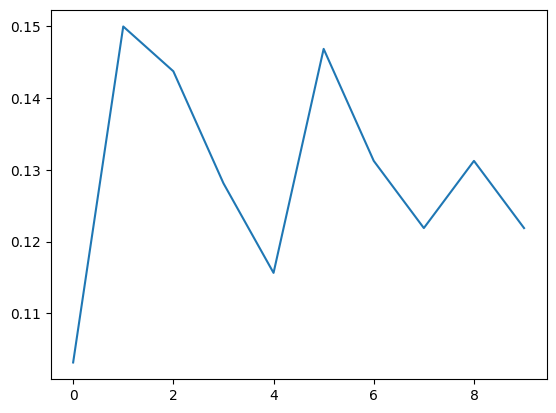

In [11]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

In [12]:
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.path: result.metrics_dataframe for result in results}

2024-06-14 18:55:20,461	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_mnist_2024-06-14_18-55-10' in 0.0124s.
2024-06-14 18:55:20,468	INFO tune.py:1041 -- Total run time: 9.77 seconds (9.73 seconds for the tuning loop).


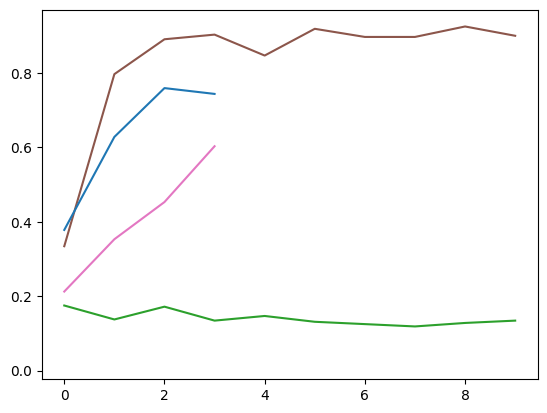

In [13]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [25]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", -10, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=10,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()

# To enable GPUs, use this instead:
# analysis = tune.run(
#     train_mnist, config=search_space, resources_per_trial={'gpu': 1})


2024-06-14 19:03:51,315	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_mnist_2024-06-14_19-03-29' in 0.0037s.
2024-06-14 19:03:51,320	INFO tune.py:1041 -- Total run time: 21.62 seconds (21.60 seconds for the tuning loop).


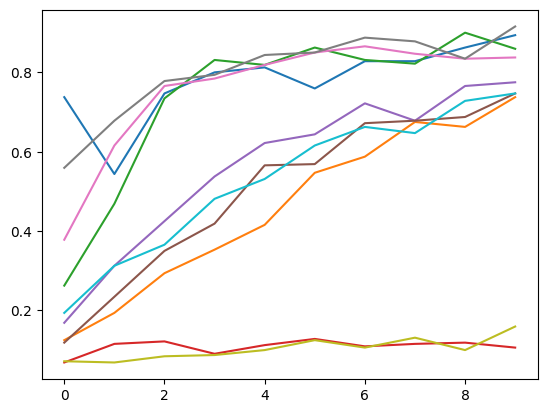

In [32]:
dfs = {result.path: result.metrics_dataframe for result in results}
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [21]:
best_result = results.get_best_result("mean_accuracy", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model = ConvNet()
model.load_state_dict(state_dict)

<All keys matched successfully>